# Pattern Analysis

In [38]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('./Sarcasm_on_Reddit/train-balanced-sarcasm.csv')
df.dropna(subset=['comment'], inplace=True)
#df = df[0:10000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


Data preprocessing

In [3]:
# Preprocess the text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

In [4]:
# Preprocess the parent comments of sarcastic comments
df['parent_tokens'] = df['parent_comment'].apply(preprocess)
sarcastic_parents = df[df['label'] == 1]['parent_tokens']

n-gram

In [52]:
# Initialize n-gram counters
unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

# Calculate n-gram
for tokens in sarcastic_parents:
    unigrams = ngrams(tokens, 1)
    bigrams = ngrams(tokens, 2)
    trigrams = ngrams(tokens, 3)
    
    unigram_counter.update(unigrams)
    bigram_counter.update(bigrams)
    trigram_counter.update(trigrams)

# Get the top 10 n-grams and their frequencies as a list of tuples in the format (n-gram, frequency)
sorted_word_freq_1gram = unigram_counter.most_common(10)
sorted_word_freq_2gram = bigram_counter.most_common(10)
sorted_word_freq_3gram = trigram_counter.most_common(10)

print("1-gram:", sorted_word_freq_1gram)
print("2-gram:", sorted_word_freq_2gram)
print("3-gram:", sorted_word_freq_3gram)

1-gram: [(('like',), 55089), (('people',), 50972), (('dont',), 44008), (('would',), 41225), (('get',), 37521), (('one',), 36056), (('im',), 35741), (('think',), 29468), (('know',), 25073), (('time',), 23367)]
2-gram: [(('dont', 'know'), 4394), (('dont', 'think'), 3389), (('gon', 'na'), 3009), (('im', 'sure'), 2811), (('dont', 'want'), 2624), (('feel', 'like'), 2394), (('looks', 'like'), 2305), (('dont', 'get'), 2133), (('year', 'old'), 1883), (('anyone', 'else'), 1877)]
3-gram: [(('im', 'pretty', 'sure'), 839), (('repost', 'repost', 'repost'), 610), (('8', '2', '8'), 559), (('2', '8', '2'), 559), (('im', 'gon', 'na'), 531), (('buzzword', 'buzzword', 'buzzword'), 317), (('would', 'like', 'see'), 302), (('dont', 'even', 'know'), 289), (('ive', 'ever', 'seen'), 255), (('gon', 'na', 'get'), 224)]


Count patterns

In [49]:
from collections import defaultdict

# Top 10 high-frequency words/n-grams as patterns
patterns = [item[0][0] for item in sorted_word_freq_1gram] + \
           [' '.join(item[0]) for item in sorted_word_freq_2gram] + \
           [' '.join(item[0]) for item in sorted_word_freq_3gram]

# Remove unwanted patterns
unwanted_patterns = {'repost repost repost', 'buzzword buzzword buzzword', '2 8 2', '8 2 8'}
patterns = [pattern for pattern in patterns if pattern not in unwanted_patterns]

# Initialize a dictionary to store the count for each pattern
pattern_counts = defaultdict(lambda: {'total': 0, 'sarcastic': 0})

# Calculate the total count and sarcastic count for each pattern
for _, row in df.iterrows():
    parent_text = ' '.join(row['parent_tokens']) 
    is_sarcastic = row['label'] == 1
    
    for pattern in patterns:
        if pattern in parent_text:
            pattern_counts[pattern]['total'] += 1
            if is_sarcastic:
                pattern_counts[pattern]['sarcastic'] += 1

# Calculate the sarcastic ratio for each pattern
for pattern, counts in pattern_counts.items():
    counts['sarcastic_ratio'] = counts['sarcastic'] / counts['total'] if counts['total'] > 0 else 0

print("Pattern counts:")
print(pattern_counts)

Pattern counts:
defaultdict(<function <lambda> at 0x0000018C8BD702C0>, {'get': {'total': 98185, 'sarcastic': 48566, 'sarcastic_ratio': 0.4946376737790905}, 'dont': {'total': 73009, 'sarcastic': 37955, 'sarcastic_ratio': 0.5198674136065417}, 'one': {'total': 166992, 'sarcastic': 83697, 'sarcastic_ratio': 0.5012036504742742}, 'im': {'total': 190895, 'sarcastic': 94938, 'sarcastic_ratio': 0.49733099347809007}, 'think': {'total': 60271, 'sarcastic': 30162, 'sarcastic_ratio': 0.5004396807751655}, 'would': {'total': 76723, 'sarcastic': 37458, 'sarcastic_ratio': 0.4882238702866155}, 'time': {'total': 59000, 'sarcastic': 28596, 'sarcastic_ratio': 0.4846779661016949}, 'people': {'total': 72304, 'sarcastic': 41947, 'sarcastic_ratio': 0.5801477096702811}, 'like': {'total': 102429, 'sarcastic': 50933, 'sarcastic_ratio': 0.49725175487410794}, 'year old': {'total': 3692, 'sarcastic': 2088, 'sarcastic_ratio': 0.5655471289274107}, 'know': {'total': 55427, 'sarcastic': 27375, 'sarcastic_ratio': 0.49389

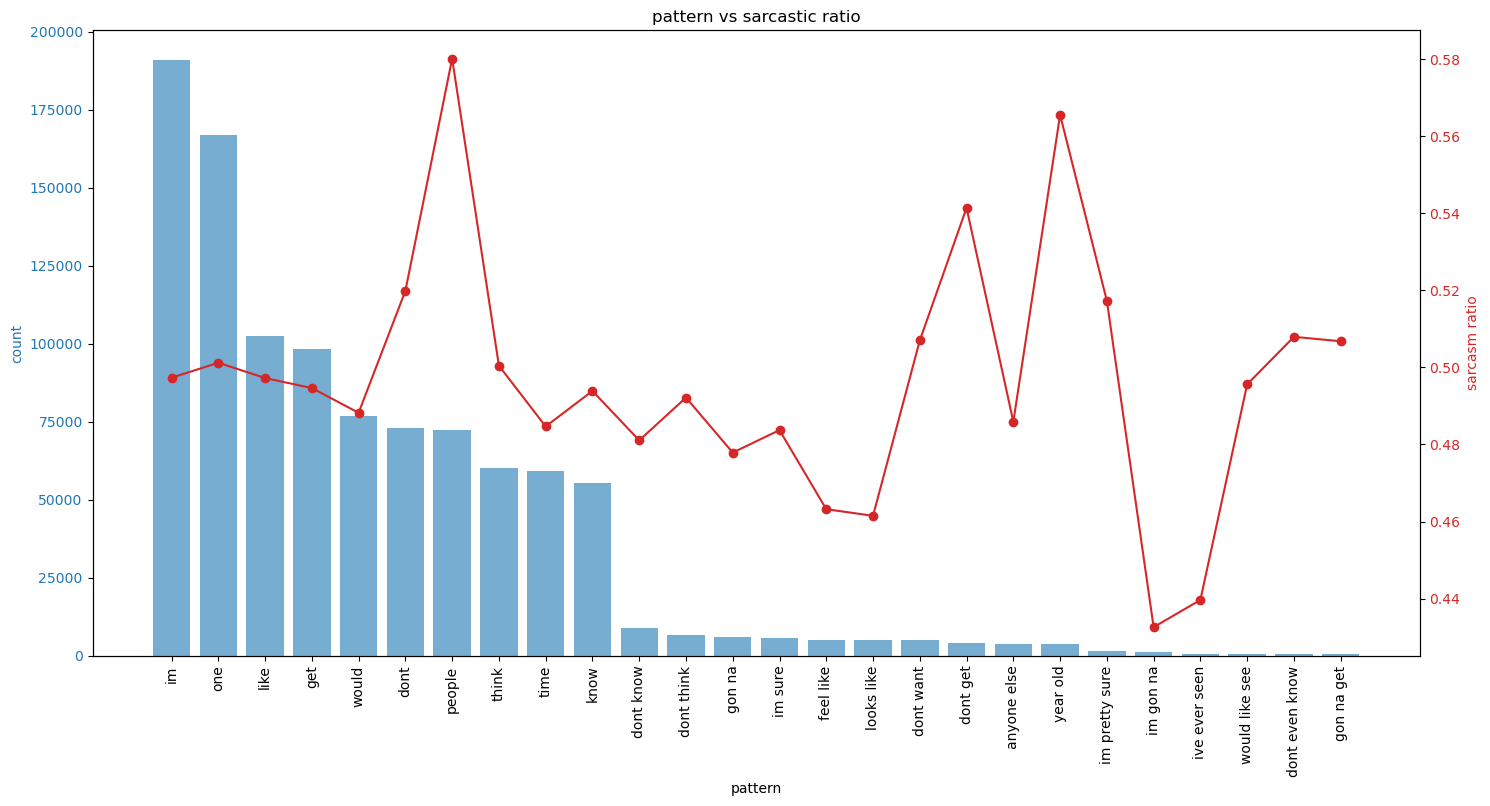

In [51]:
# Sort the pattern counts by total count
sorted_pattern_counts = sorted(pattern_counts.items(), key=lambda item: item[1]['total'], reverse=True)

patterns = [item[0] for item in sorted_pattern_counts]
total_counts = [item[1]['total'] for item in sorted_pattern_counts]
sarcastic_ratios = [item[1]['sarcastic_ratio'] for item in sorted_pattern_counts]

# Plot the total count and sarcastic ratio for each pattern
fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('pattern')
ax1.set_ylabel('count', color=color)
ax1.bar(patterns, total_counts, color=color, alpha=0.6, label='total count')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('sarcasm ratio', color=color)
ax2.plot(patterns, sarcastic_ratios, color=color, marker='o', linestyle='-', label='sarcasm ratio')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('pattern vs sarcastic ratio')
plt.show()